In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Testing User Recommendation matrix

In this step dataset preprocessed in previous step is loaded and simple baseline model is tested.

Each line in a dataset contains data about one user and his final action on the offer. 
Either offer has been ignored, viewed or completed (offer proved to be interesting to a customer).

In [2]:
df = pd.read_csv('./userdata.csv')

In [3]:
df.head()

,age,became_member_on,gender,id,income,memberdays,event,time,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,118,20170212,0,68be06ca386d4c31939f3a4f0e3dd783,0,1162,1.0,216.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
1,68,20180426,2,e2127556f4f64592b11af22de27a7932,4,724,1.0,18.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
2,118,20170925,0,8ec6ce2a7e7949b1bf142def7d0e0586,0,937,1.0,462.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
3,118,20171002,0,68617ca6246f4fbc85e91a2a49552598,0,930,1.0,432.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
4,65,20180209,2,389bc3fa690240e798340f5a15918d5c,3,800,2.0,498.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0


In [4]:
print("Dataset contains %s actions:", len(df))

Dataset contains %s actions: 72628


### Let's plot the actions for one user

From the output can be seen that user completed an offer `0b1e...` and viewed `ae26...`. Offer `2906..` had been ignored twice.

In [5]:

df[df.id == 'e12aeaf2d47d42479ea1c4ac3d8286c6' ]

,age,became_member_on,gender,id,income,memberdays,event,time,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
5,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,0.0,168.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
6,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,0.0,576.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
7146,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,2.0,456.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,1,0,0,0,1,0
50876,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,1.0,414.0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,0,1,1,1,1,0,0


### Preparing data for training
Let's create user-offer matrix by encoding each id into categorical value.

In [6]:
def to_categorical(df, columns):
    for col in columns:
        df[col] = pd.Categorical(df[col])
        df[col] = df[col].cat.codes
    return df

In [7]:
df = to_categorical(df, ['id', 'offer_id', 'event'])
df.dtypes

age                   int64
became_member_on      int64
gender                int64
id                    int16
income                int64
memberdays            int64
event                  int8
time                float64
offer_id               int8
difficulty            int64
duration              int64
reward                int64
web                   int64
email                 int64
mobile                int64
social                int64
bogo                  int64
discount              int64
informational         int64
dtype: object

Recommendation matrix is very similar to embeddings. So we will leverage this and will train embedding along the model.

In [8]:
# Set embedding sizes
N = len(df['id'].unique())
M = len(df['offer_id'].unique())

# Set embedding dimension
D = 100

In [11]:
offer_specs = ['difficulty', 'duration', 'reward', 'web',
       'email', 'mobile', 'social', 'bogo', 'discount', 'informational']
user_specs = ['age', 'became_member_on', 'gender', 'income', 'memberdays']

In [12]:
# Create a neural network that takes additional continuous paramets
class Model(nn.Module):
    def __init__(self, n_users, n_items, n_cont_user, n_cont_offer, embed_dim, output_dim, layers=[1024], p=0.4):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim
        self.bn_cont_u = nn.BatchNorm1d(n_cont_user)
        self.bn_cont_o = nn.BatchNorm1d(n_cont_offer)
        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        
        layerlist = []
        n_in = 2 * self.D + n_cont_user + n_cont_offer
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU())
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],output_dim))
        self.layers = nn.Sequential(*layerlist)
        
        nn.init.xavier_uniform_(self.layers[0].weight)
        nn.init.zeros_(self.layers[0].bias)
        nn.init.xavier_uniform_(self.layers[-1].weight)
        nn.init.zeros_(self.layers[-1].bias)

    def forward(self, user, offer, user_details, offer_details):
        u = self.u_emb(user) # output is (num_samples, D)
        m = self.m_emb(offer) # output is (num_samples, D)

        # merge
        out = torch.cat((u, m), 1) # output is (num_samples, 2D)
        u_cont = self.bn_cont_u(user_details)
        o_cont = self.bn_cont_o(offer_details)
        out = torch.cat([out, u_cont, o_cont], 1)
        x = self.layers(out)
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Model(N, M, 
              n_cont_user=df[user_specs].shape[1], 
              n_cont_offer=df[offer_specs].shape[1],
              embed_dim=D, 
              output_dim=df['event'].nunique(), 
              layers=[512, 256])
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

cpu


In [14]:
model

Model(
  (bn_cont_u): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cont_o): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (u_emb): Embedding(16994, 100)
  (m_emb): Embedding(10, 100)
  (layers): Sequential(
    (0): Linear(in_features=215, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)

### Create additional user and offer details tensors

In [87]:
# Convert to tensors
# Make datasets
# We name events as rating for give better insight on the target value
# and ease of comparison to other similar models

user_ids_t = torch.from_numpy(df['id'].values).long()
offer_ids_t = torch.from_numpy(df['offer_id'].values).long()
ratings_t = torch.from_numpy(df['event'].values).long()

user_params_t = torch.from_numpy(df[user_specs].values).float()
offer_params_t = torch.from_numpy(df[offer_specs].values).float()

In [88]:
# Make datasets
N_train = int(0.8 * len(df['event'].values))
N_test = 1000
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:N_train],
    offer_ids_t[:N_train],
    user_params_t[:N_train],
    offer_params_t[:N_train],
    ratings_t[:N_train],
)

val_dataset = torch.utils.data.TensorDataset(
    user_ids_t[N_train:-N_test],
    offer_ids_t[N_train:-N_test],
    user_params_t[N_train:-N_test],
    offer_params_t[N_train:-N_test],
    ratings_t[N_train:-N_test],
    
)
test_df = df[-N_test:]

In [89]:
# Data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [92]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
    
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    acc_list = []
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for users, offers, u_params, o_params, targets in train_loader:
            

            # move data to GPU
            users, offers, u_params, o_params, targets = users.to(device), offers.to(device),  u_params.to(device), o_params.to(device), targets.to(device)
            #targets = targets.view(-1, 1).long()
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(users, offers, u_params, o_params)
            
            loss = criterion(outputs, targets.squeeze())

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
            # Track the accuracy
            total = targets.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == targets).sum().item()
            acc = correct / total
            acc_list.append(acc)

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
        
        val_loss = []
        
        # validation
        with torch.no_grad():
            model.eval()
            
            for users, offers, u_params, o_params, targets in validation_loader:
                users, offers, u_params, o_params, targets = users.to(device), offers.to(device),  u_params.to(device), o_params.to(device), targets.to(device)
                #targets = targets.view(-1, 1).long()
                outputs = model(users, offers, u_params, o_params)
                loss = criterion(outputs, targets.squeeze())
                val_loss.append(loss.item())
        
        val_loss = np.mean(val_loss)
        # Save losses
        train_losses[it] = train_loss
        val_losses[it] = val_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
              f'Talidations Loss: {val_loss:.4f}, Accuracy: {acc}, Duration: {dt}')

    return train_losses, val_losses

Epoch 1/25, Validation Loss: 0.3289, Test Loss: 2.9901, Accuracy: 0.9090909090909091, Duration: 0:01:09.865855
Epoch 2/25, Validation Loss: 0.2404, Test Loss: 4.5451, Accuracy: 0.9090909090909091, Duration: 0:01:11.126845
Epoch 3/25, Validation Loss: 0.1635, Test Loss: 6.3175, Accuracy: 1.0, Duration: 0:02:58.673628
Epoch 4/25, Validation Loss: 0.1013, Test Loss: 8.1232, Accuracy: 1.0, Duration: 0:06:58.201211
Epoch 5/25, Validation Loss: 0.0635, Test Loss: 11.9013, Accuracy: 1.0, Duration: 0:05:16.551870
Epoch 6/25, Validation Loss: 0.0458, Test Loss: 13.5115, Accuracy: 1.0, Duration: 0:05:41.915169
Epoch 7/25, Validation Loss: 0.0352, Test Loss: 16.7594, Accuracy: 1.0, Duration: 0:07:52.862564
Epoch 8/25, Validation Loss: 0.0289, Test Loss: 20.2389, Accuracy: 1.0, Duration: 0:06:14.368786
Epoch 9/25, Validation Loss: 0.0266, Test Loss: 20.2717, Accuracy: 1.0, Duration: 0:05:16.878737
Epoch 10/25, Validation Loss: 0.0206, Test Loss: 22.4632, Accuracy: 1.0, Duration: 0:06:57.885297
Epo

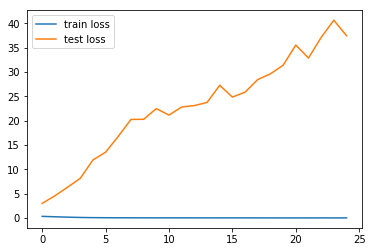

In [ ]:
train_losses, val_losses = batch_gd( \
    model, criterion, optimizer, train_loader, validation_loader, 25)

# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='test loss')
plt.legend()
plt.show()

In [95]:
start_ix = 10
end_ix = 20
test_X =  torch.from_numpy(test_df.iloc[start_ix:end_ix]['id'].values).long()
test_y = torch.from_numpy(test_df.iloc[start_ix:end_ix]['event'].values).long()
user_params_t = torch.from_numpy(test_df.iloc[start_ix:end_ix][user_specs].values).float()
offer_params_t = torch.from_numpy(test_df.iloc[start_ix:end_ix][offer_specs].values).float()

with torch.no_grad():
    
    model.eval()
    pred = model(test_X, test_y, user_params_t, offer_params_t)
    print(pred)
_, predicted = torch.max(pred.data, 1)
print(predicted)

tensor([[  2.7183, -18.5404,  18.3340],
        [-34.8334,  16.9431,  -1.4971],
        [-34.8334,  16.9431,  -1.4971],
        [-23.1324,  11.3861,  -0.8747],
        [-10.6528, -41.2570,  45.8215],
        [  2.7268,  -6.3247,   9.4654],
        [-13.3838,   6.5185,   3.2080],
        [ -1.0037, -16.4810,  15.4425],
        [-66.7932,  36.6516,  -0.6167],
        [-21.3421,  -8.3732,  26.0564]])
tensor([2, 1, 1, 1, 2, 2, 1, 2, 1, 2])


In [96]:
from sklearn.metrics import confusion_matrix,  accuracy_score
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#### Plot confusion matrix and baseline accuracy

Confusion matrix, without normalization
[[4 1]
 [1 4]]


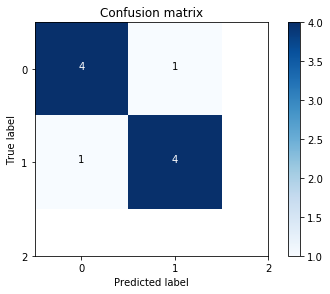

In [97]:
cm = confusion_matrix(test_y, predicted)
classes = [0,1,2]
plot_confusion_matrix(cm, classes)

In [98]:
print("Accuracy so far: " + str(100*accuracy_score(test_y, predicted))+ "%" )

Accuracy so far: 80.0%


Results are decent so far and almost twice better than random quessing.

#### Show some predicted examples

In [124]:
data = test_df.iloc[start_ix:end_ix][['age', 'became_member_on', 'gender', 'id', 'income', 'memberdays', 'event']]#['offer_id'].values
pred_values = pd.DataFrame(predicted, columns=['predicted'], index=data.index)
results = pd.concat([data, pred_values], axis=1)
results

,age,became_member_on,gender,id,income,memberdays,event,predicted
71638,42,20170806,2,11854,4,987,2,2
71639,118,20150829,0,6712,0,1695,1,1
71640,118,20150829,0,6712,0,1695,1,1
71641,47,20180427,3,5350,3,723,1,1
71642,70,20160325,3,6908,3,1486,2,2
71643,59,20160815,2,14044,6,1343,2,2
71644,49,20171110,2,11158,5,891,2,1
71645,73,20170626,2,3378,2,1028,2,2
71646,41,20161212,2,11261,1,1224,1,1
71647,49,20170428,2,9752,4,1087,1,2


From the output we see that for randomly selected 10 users model was inaccurate twice, but was able to predict user positive actions on offer.

Mislassifications:

In [130]:
results.iloc[[6,9],:]

,age,became_member_on,gender,id,income,memberdays,event,predicted
71644,49,20171110,2,11158,5,891,2,1
71647,49,20170428,2,9752,4,1087,1,2


Now let's save the model for future reference

In [101]:
#!mkdir model
import os

def save_model(model, model_name, model_info):
    # Save the parameters used to construct the model
    with open(model_name, 'wb') as f:
        torch.save(model_info, f)

    # Save the model parameters
    
    with open(model_name, 'wb') as f:
        torch.save(model.cpu().state_dict(), f)

model_info = {    
          'n_users': M, 
          'n_items': N, 
          'n_cont_user': df[user_specs].shape[1], 
          'n_cont_offer': df[offer_specs].shape[1],
          'embed_dim': D, 
          'output_dim': df['event'].nunique(), 
          'layers': [512, 256], 
          'p': 0.4
    }
save_model(model, './model/RecommendationModel.pth', model_info)